In [65]:
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
import random
import math
import picos
import cvxopt
import pickle
import mosek
import time
from krotov.parametrization import ParametrizedFunction, SquareParametrization, TanhParametrization

# Set Hyperparameters

One should make sure that the number of time steps (variable of "steps" below) is reasonably larger than the annealing time $T$. This is because if one increases annealing time $T$ and fixes number of time steps, the evolution becomes more and more inaccruate. Hence, once one evolves the Hamiltonian equipped to the pulse sequences, the final state will depend on what methods one evolves the Hamiltonian. For instance, using propagator in Krotov package will give different final state from using mesolve function in Qutip package. This will make unfair to compare with the results drawn from HOQST as well. 

I checked that setting the number of steps equal to $10 \times T$ makes the evolution smooth enough so that the final states evolved from Krotov propagator and Qutip mesolve are the same.

Also, make sure you increse annealing time as you increase number of qubits.

In [30]:
nq = 3 #number of qubits
T = 10 #annealing time
steps = T*10 #time steps 
tlist = np.linspace(0, T, steps)

# Define Hamiltonian

The system Hamiltonian we will be using now is in the form of: 

$H(t) = \sum_{i=1}^{n} \epsilon_i(t) X_i + \sum_{i=1}^{n} \epsilon_{i+n}(t) Z_i - \sum_{i=1}^{n-1} Z_iZ_{i+1}, $

where $n$ is the number of qubits. In addition, we will initiaize guess control functions equipped to the initial counditions of ${\epsilon}_{i=1,...n} (t=0) = 0$ (pulse coefficients of $X_i$) and ${\epsilon}_{i=n+1,...,2n} (t=0) = 1$, which gives the ground state of $\lvert{11...11}\rangle$.

In [31]:
#set matrices for each Hamiltonian terms, X_i, Z_i, and Z_iZ_i+1
Hx_local,Hz_local,Hz_2local=[],[],[]
for i in range(nq):
    argsX=[qutip.qeye(2) for _ in range(nq)]; argsX[i]=qutip.sigmax()
    argsZ=[qutip.qeye(2) for _ in range(nq)]; argsZ[i]=qutip.sigmaz()
    Hx_local.append(qutip.tensor(*argsX)); Hz_local.append(qutip.tensor(*argsZ))
    
    if i < nq-1:
        argsZZ=[qutip.qeye(2) for _ in range(nq)]; argsZZ[i]=qutip.sigmaz(); argsZZ[i+1]=qutip.sigmaz()
        Hz_2local.append(qutip.tensor(*argsZZ))

#re-dimension
for h in Hx_local, Hz_local, Hz_2local:
    for g in h:
        g.dims=[[2**nq],[2**nq]]; 

    

In [32]:
#eps_max, min are bounds on control amplitudes. Set this if needed. If not, get rid of ParametrizedFunction options

def generate_ham(hamiltonian, pauli,k):
    if pauli == 'X':
        return [hamiltonian[k], ParametrizedFunction(lambda t, args: np.sin(10*t/T), 
                TanhParametrization(eps_max=1.0, eps_min=-1.0))]
    elif pauli == 'Z':
        return [hamiltonian[k], ParametrizedFunction(lambda t, args: np.cos(10*t/T), 
                TanhParametrization(eps_max=1.0, eps_min=-1.0))]

In [33]:
#generate the system hamiltonian
if nq==1:
    H = [qutip.qzero(2)] + [generate_ham(Hx_local, 'X', i) for i in range(nq)] + [generate_ham(Hz_local, 'Z', i) for i in range(nq)]
else:
    H = [-Hzz for Hzz in Hz_2local] + [generate_ham(Hx_local, 'X', i) for i in range(nq)] + [generate_ham(Hz_local, 'Z', i) for i in range(nq)]

# Customize the Cost Function

This part is required if one tries to use specific forms of cost function other than listed in Krotov package(https://qucontrol.github.io/krotov/v1.0.0/API/krotov.functionals.html). 

Here, we might want to use the following form for the generator: $J_T = \lvert \text{Tr}(D\sigma-D\rho(T)) \rvert ^2$ where $\sigma=\lvert \psi_{targ} \rangle \langle \psi_{targ} \rvert$ is a target state and $\rho(T)=\lvert \psi(T) \rangle \langle \psi(T) \rvert$ is a fully time-evolved state. 

Krotov's method requires to enter $-\frac{\partial J}{\partial \langle \psi_k \rvert} = -2 (\langle \psi(T) \rvert D\lvert \psi(T)\rangle -  \langle \psi_{targ} \rvert D\lvert \psi_{targ}\rangle) \cdot D\lvert \psi(T)\rangle$, which is described in chis_qubit function below. print_qubit_error function is for print out the cost function during optimization.

In [34]:
def print_qubit_error(**args):
    """Utility function writing the qubit error to screen"""
    taus = []
    for state_T in args['fw_states_T']:
        exp = qutip.expect(D, state_T)
        taus.append(exp)
        
    J_T_re = np.average(taus)
    
    exp_D = qutip.expect(D, psi_targ)
    
    #J = J_T_re - exp_D
    
    J = abs(J_T_re-exp_D)**2
    
    print("    |<psi|D|psi> - <target|D|target>|^2: %.le"% (J) )
    
    return J
        

In [35]:
def chis_qubit(fw_states_T, objectives, tau_vals):
    """Calculate chis for the chosen functional"""
    chis = []
    #print(fw_states_T)
    for state_i_T in fw_states_T:
        #print(D)
        #chi=-(D*state_i_T)
        c = qutip.expect(D, psi_targ)
        o = qutip.expect(D, state_i_T)
        
        #chi= -2*(o-c)*(D*state_i_T)
        
        chi=-2*(state_i_T.dag()*(D*state_i_T) - c)*(D*state_i_T)
        chis.append(chi)
    return chis

# Shape Function

Krotov's method requires shape function, which is used to optimize pulse sequence in each time grid. The shape function should be defined in the same time grid and indicates how much pulse value (at each time grid) is changed in a single optimization. For instance, $S(t=0) = 0$ will prevent from pulse value at $t=0$ changing. (check: https://qucontrol.github.io/krotov/v1.0.0/07_krotovs_method.html?highlight=shape%20#first-order-update)

The design of such shape function is completely up to the user.

In [36]:
def S(t):
    """Shape function for the field update"""
    
    return krotov.shapes.flattop(t, t_start=0, t_stop=T, t_rise=(T / 20), t_fall=(T / 20), func='sinsq')

# Initial/Target States

Create initial state; here we want to start from the ground state of initial Hamiltomian we defined earlier. The ground state should be $\lvert 11..11\rangle$. 

In [37]:
#produce initial hamiltonian, i.e. H(t=0)
h0=0
for h in Hz_local,Hz_2local:
    for g in h:
        if h == Hz_local:
            h0+=g
        else:
            h0+=-g

In [38]:
psi_init = h0.eigenstates()[1][0] 
rho_init=psi_init * psi_init.dag()
psi_init

Quantum object: dims = [[8], [1]], shape = (8, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]

In [39]:
objectives = [krotov.Objective(initial_state=psi_init, target=0, H=H)]

# Choose initial operator for discriminator, $D_0$

In [40]:
for i in range(nq):
    argsZ=[qutip.qeye(2) for _ in range(nq)]; argsZ[0]=qutip.sigmaz()

D0 = qutip.tensor(*argsZ)
D0.dims=[[2**nq],[2**nq]]
D0

Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.]]

In [41]:
targ_states = [(qutip.basis(2**nq,0)+qutip.basis(2**nq,2**nq-1))/np.sqrt(2)]
targ_states 

[Quantum object: dims = [[8], [1]], shape = (8, 1), type = ket
 Qobj data =
 [[0.70710678]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.70710678]]]

# Optimization

In [45]:
#it = number of iterations taken in each step of the generator; 
#lam = stepsize of generator; #total_it: iterations of QGAN
lam =10.0; total_it = 1500

#choose discriminator:
dis = 'Helstrom'

In [43]:
def generate_ham_check(hamiltonian, pauli,k,j, pl):
    if pauli == 'X':
        return [hamiltonian[k], np.array(pl[j])]
    elif pauli == 'Z':
        return [hamiltonian[k], np.array(pl[j])]

In [44]:
start = time.time()

#D, pulse, fidelity list, states
tD, tP, tF, tS = [],[],[],[]


for state in targ_states: 
    
    #set preliminaries & store initial values of D and initial pulse
    D_list,pulse_list,fid_list,state_list=[],[],[],[]
    
    dis_pulse_list=[]
    
    #define target state & set initial D as D0
    psi_targ = state; rho_targ = psi_targ * psi_targ.dag(); D= D0; it=5; add=it

    #Store initial pulse & define pulse_options
    init_pulse=[]
    if nq == 1:
        pulse_options={}; H_param = [H[i][1] for i in range(1,3)]
        for h in H_param:
            pulse_options[h] = dict(lambda_a=lam, update_shape=S)
        for i in range(1,3):
            init_pulse.append(np.array([H[i][1](t, args=None) for t in tlist]))
    
    else:
        pulse_options={}; H_param = [H[i][1] for i in range(nq-1, 2*nq+(nq-1))]
        for h in H_param:
            pulse_options[h] = dict(lambda_a=lam, update_shape=S)
        for i in range(nq-1,2*nq+(nq-1)):
            init_pulse.append(np.array([H[i][1](t, args=None) for t in tlist]))
    
    D_list.append(D); pulse_list.append(init_pulse)

    
    #Generator


    for i in range(total_it):

        print(str(i)+'th step of QGAN begins')
        
        #optimize pulse

        if i == 0:
            
            opt_result = krotov.optimize_pulses(
            objectives,
            pulse_options,
            tlist,
            propagator=krotov.propagators.expm,
            chi_constructor=chis_qubit,
            iter_stop = it,
            info_hook=krotov.info_hooks.chain(print_qubit_error),
            check_convergence = krotov.convergence.value_below(limit='1e-22'))

        else:

            opt_result = krotov.optimize_pulses(
            objectives,
            pulse_options,
            tlist,
            propagator=krotov.propagators.expm,
            chi_constructor=chis_qubit,
            iter_stop = it,
            info_hook=krotov.info_hooks.chain(print_qubit_error),
            check_convergence = krotov.convergence.value_below(limit='1e-22'),
            continue_from=opt_result)

        pulse_list.append(opt_result.optimized_controls)
        #cost_list.append(opt_result.info_vals[-1])

        final_state = opt_result.states[0] #final state
        state_list.append(final_state)

        rhot = final_state * final_state.dag() #rho_optimized

        it+=add

        fid_list.append(qutip.fidelity(psi_targ, final_state)**2)

        print('fidelity: ' + str(qutip.fidelity(psi_targ, final_state)**2))

        #convergence check: fidelity > 0.999
        if qutip.fidelity(psi_targ, final_state)**2 > 0.999: 
            print('converged at ' + str(i) + 'th step') 
            break


        # Discriminator
        
        if dis == 'Helstrom':
            
            pm = (rhot-rho_targ).eigenstates()[1][-1]*(rhot-rho_targ).eigenstates()[1][-1].dag()
            pn = (rhot-rho_targ).eigenstates()[1][0]*(rhot-rho_targ).eigenstates()[1][0].dag()


            D = 0.5*(pm - pn)
            D.dims = [[2**nq], [2**nq]]
            D_list.append(D)
        
        else:
            
            pulse_options_D = pulse_options

            L=krotov.objectives.liouvillian(H, c_ops={})
            objectives_D = [krotov.Objective(initial_state=(rhot - rho_targ), target=D0, H=L)]

            opt_result_D = krotov.optimize_pulses(
            objectives_D,
            pulse_options_D,
            tlist,
            propagator=krotov.propagators.DensityMatrixODEPropagator(),
            chi_constructor=krotov.functionals.chis_re,
            iter_stop = 1,
            info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.F_re))

            final_state_D = opt_result_D.states[0]
            #print(final_state_D)

            print(np.trace(D0*final_state_D))
            rp=opt_result_D.optimized_controls
            dis_pulse_list.append(rp)

            H_check = [-Hzz for Hzz in Hz_2local] + [generate_ham_check(Hx_local, 'X', i, i, rp) for i in range(nq)] \
            + [generate_ham_check(Hz_local, 'Z', i, i+nq, rp) for i in range(nq)]

            U=qutip.propagator(H_check, tlist)[-1]
            D = (U.dag())*(D0*U)
            D_list.append(D)
        
    tD.append(D_list); tP.append(pulse_list); tF.append(fid_list); tS.append(state_list)
    
end = time.time()

total_time = end-start

0th step of QGAN begins
    |<psi|D|psi> - <target|D|target>|^2: 1e-03


/Users/leeseok/opt/anaconda3/lib/python3.9/site-packages/krotov/parametrization.py:66: UserWarning: Pulse value 1.0 out of range (-1.0, 1.0) for TanhParametrization. Value will be clipped.
  warnings.warn(


    |<psi|D|psi> - <target|D|target>|^2: 2e-04
    |<psi|D|psi> - <target|D|target>|^2: 6e-05
    |<psi|D|psi> - <target|D|target>|^2: 1e-05
    |<psi|D|psi> - <target|D|target>|^2: 3e-06
    |<psi|D|psi> - <target|D|target>|^2: 7e-07
fidelity: 0.33482372445549413
1th step of QGAN begins
    |<psi|D|psi> - <target|D|target>|^2: 7e-01
    |<psi|D|psi> - <target|D|target>|^2: 6e-01
    |<psi|D|psi> - <target|D|target>|^2: 5e-01
    |<psi|D|psi> - <target|D|target>|^2: 5e-01
    |<psi|D|psi> - <target|D|target>|^2: 4e-01
    |<psi|D|psi> - <target|D|target>|^2: 3e-01
fidelity: 0.6494292812047677
2th step of QGAN begins
    |<psi|D|psi> - <target|D|target>|^2: 4e-01
    |<psi|D|psi> - <target|D|target>|^2: 3e-01
    |<psi|D|psi> - <target|D|target>|^2: 3e-01
    |<psi|D|psi> - <target|D|target>|^2: 2e-01
    |<psi|D|psi> - <target|D|target>|^2: 2e-01
    |<psi|D|psi> - <target|D|target>|^2: 1e-01
fidelity: 0.8414130481247283
3th step of QGAN begins
    |<psi|D|psi> - <target|D|target>|^2: 

# Results

Plot to see how pulse sequences and fidelity changed over optimization

In [51]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots(figsize=(10,6))
    Ham = ['amps of X1', 'amps of X2', 'amps of Z1', 'amps of Z2']
    for i in range(len(pulse)):
        ax.plot(tlist, pulse[i])#, label=str(Ham[i]))
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    ax.legend(bbox_to_anchor=(0.9, 0.3))
    plt.show(fig)

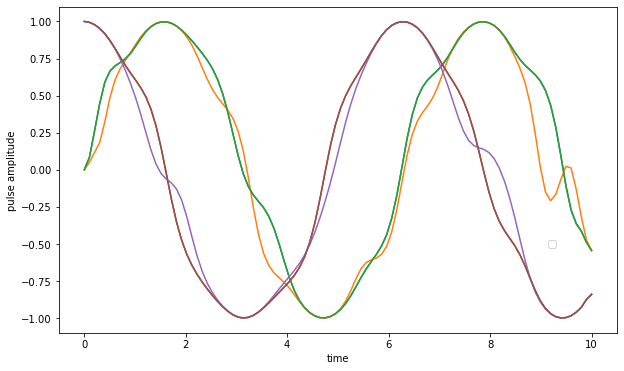

In [52]:
plot_pulse(pulse_list[-1], tlist)

In [53]:
def plot_fid(fid_list):
    fig, ax = plt.subplots()
    f = len(fid_list)
    
    ax.plot(np.linspace(1,f, f), fid_list)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
          
    ax.set_xlabel('iteration', fontsize = 18)
    ax.set_ylabel('fidelity', fontsize = 18)
    fig.show()

/var/folders/9r/1h6y9d_s679362wyg5rjyqm40000gn/T/ipykernel_61775/3072373806.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


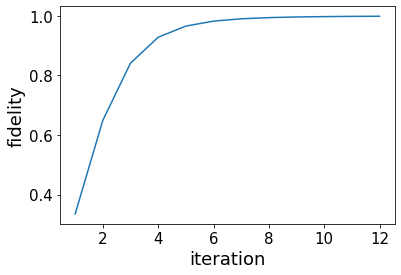

In [54]:
plot_fid(tF[0])

# Sanity Check

Check whether the state is accurate

In [55]:
opt_states = opt_result.optimized_objectives[0].propagate(tlist, propagator=krotov.propagators.expm).states

In [56]:
opt_states[-1]

Quantum object: dims = [[8], [1]], shape = (8, 1), type = ket
Qobj data =
[[-0.66099266-0.2282229j ]
 [ 0.00744244-0.00484733j]
 [-0.01624754+0.01298591j]
 [-0.00873143-0.00299562j]
 [ 0.00751469-0.00490479j]
 [-0.00169126+0.00920258j]
 [-0.00880061-0.0029624j ]
 [-0.67442099-0.23517724j]]

In [57]:
tS[0][-1]

Quantum object: dims = [[8], [1]], shape = (8, 1), type = ket
Qobj data =
[[-0.66099266-0.2282229j ]
 [ 0.00744244-0.00484733j]
 [-0.01624754+0.01298591j]
 [-0.00873143-0.00299562j]
 [ 0.00751469-0.00490479j]
 [-0.00169126+0.00920258j]
 [-0.00880061-0.0029624j ]
 [-0.67442099-0.23517724j]]

Another way to check is whether this state is correct is by using mesolve: (mesolve might give a very slightly different state since calculation method is different: check(https://qucontrol.github.io/krotov/v1.2.0/API/krotov.propagators.html and https://qutip.org/docs/latest/apidoc/functions.html#qutip.mesolve.mesolve)

In [58]:
def generate_ham_check(hamiltonian, pauli,k,j):
    if pauli == 'X':
        return [hamiltonian[k], np.array(pulse_list[-1][j])]
    elif pauli == 'Z':
        return [hamiltonian[k], np.array(pulse_list[-1][j])]

In [59]:
H_check = [-Hzz for Hzz in Hz_2local] + \
[generate_ham_check(Hx_local, 'X', i, i) for i in range(nq)] + [generate_ham_check(Hz_local, 'Z', i, i+nq) for i in range(nq)]

In [60]:
qutip.mesolve(H_check, psi_init, tlist).states[-1]

Quantum object: dims = [[8], [1]], shape = (8, 1), type = ket
Qobj data =
[[-6.61656766e-01-0.22582013j]
 [ 8.34056661e-03-0.0003077j ]
 [-2.31815282e-02+0.01486146j]
 [-9.70472695e-03-0.00691004j]
 [ 8.37161532e-03-0.00037338j]
 [-1.21904708e-04+0.01334073j]
 [-9.78280195e-03-0.00685021j]
 [-6.75890192e-01-0.23027671j]]

In [61]:
qutip.fidelity(qutip.mesolve(H_check, psi_init, tlist).states[-1], tS[0][-1])

0.9999242939458041